In [1]:
%load_ext autoreload

In [2]:
import random
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM

if not "../data_processing" in sys.path:
    sys.path.append("../data_processing")

%autoreload
import build_dataset

ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
appended
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


In [3]:
def train_test_split(df, percentage):
    split_index = int(np.floor(df.shape[0]) * percentage)
    train = df[:split_index]
    test = df[split_index:].reset_index(drop=True)
    return train, test

### Load Datasets

In [4]:
wt1_path = '/Volumes/OsvikExtra/VibrationData/RMS_dataset/GbxHssRr_RMS_WTG01.csv'
wt1 = pd.read_csv(wt1_path)

wt2_path = '/Volumes/OsvikExtra/VibrationData/RMS_dataset/GbxHssRr_RMS_WTG02.csv'
wt2 = pd.read_csv(wt2_path)

wt3_path = '/Volumes/OsvikExtra/VibrationData/RMS_dataset/GbxHssRr_RMS_WTG03.csv'
wt3 = pd.read_csv(wt3_path)

wt4_path = '/Volumes/OsvikExtra/VibrationData/RMS_dataset/GbxHssRr_RMS_WTG04.csv'
wt4 = pd.read_csv(wt4_path)


### Process data

In [5]:
# Remove uninteresting columns
wt1_mod = wt1.drop(columns=['ActPower','WindSpeed', 'NacelleDirection'])
wt2_mod = wt2.drop(columns=['ActPower','WindSpeed', 'NacelleDirection','RMS_component_interval'])
wt3_mod = wt3.drop(columns=['ActPower','WindSpeed', 'NacelleDirection'])
wt4_mod = wt4.drop(columns=['ActPower','WindSpeed', 'NacelleDirection'])


# Filter data sets IMPORTANT STEP
wt1_mod = wt1_mod.drop(wt1_mod[wt1_mod.AvgRotSpeed < 1400].index)
wt2_mod = wt2_mod.drop(wt2_mod[wt2_mod.AvgRotSpeed < 1400].index)
wt3_mod = wt3_mod.drop(wt3_mod[wt3_mod.AvgRotSpeed < 1400].index)
wt4_mod = wt4_mod.drop(wt4_mod[wt4_mod.AvgRotSpeed < 1400].index)


# Add target to each data set. Turbine 2 and 3 have target = 0 as they are OK. Tubine 1 has target = 1 as it has 
# faulty behavior. Turbine 4 has target = 2 as it has the most faulty behavior.
wt1_mod.insert(0, 'Target', np.ones(wt1_mod.shape[0]))
wt2_mod.insert(0, 'Target', np.ones(wt2_mod.shape[0])*2)
wt3_mod.insert(0, 'Target', np.ones(wt3_mod.shape[0])*3)
wt4_mod.insert(0, 'Target', np.ones(wt4_mod.shape[0])*4)

### Split into training and testing

In [6]:
# Split each turbine data set into training and testing
wt1_train, wt1_test = train_test_split(wt1_mod, 0.5)
wt2_train, wt2_test = train_test_split(wt2_mod, 0.5)
wt3_train, wt3_test = train_test_split(wt3_mod, 0.5)
wt4_train, wt4_test = train_test_split(wt4_mod, 0.5)

### Selecting GbxHssRr_RMS_13  and GbxHssRr_RMS_30  as features

In [7]:
# Separate features from target
wt1_X_train_small = wt1_train.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt1_y_train       = wt1_train['Target']
wt1_X_test_small  = wt1_test.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt1_y_test        = wt1_test['Target']

wt2_X_train_small = wt2_train.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt2_y_train       = wt2_train['Target']
wt2_X_test_small  = wt2_test.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt2_y_test        = wt2_test['Target']

wt3_X_train_small = wt3_train.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt3_y_train       = wt3_train['Target']
wt3_X_test_small  = wt3_test.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt3_y_test        = wt3_test['Target']

wt4_X_train_small = wt4_train.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt4_y_train       = wt4_train['Target']
wt4_X_test_small  = wt4_test.loc[:, ['GbxHssRr_RMS_13', 'GbxHssRr_RMS_30']]
wt4_y_test        = wt4_test['Target']

## One Class SVM for normal behavior (Turbine 2 and 3)

In [9]:
clf = OneClassSVM(gamma='auto', shrinking=False, nu=0.01)
clf.fit(wt2_X_train_small)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.01, random_state=None, shrinking=False, tol=0.001,
      verbose=False)

In [10]:
pred = clf.predict(wt3_X_train_small)

score = pred>0
score.mean()

0.9875776397515528

In [11]:
z = np.linspace(0,2,200)

In [12]:
xx1, xx2 = np.meshgrid(z,z)
df = pd.DataFrame()
df['GbxHssRr_RMS_13'] = xx1.ravel()
df['GbxHssRr_RMS_30'] = xx2.ravel()
df['y_hat'] = clf.predict(df)
df.head()

,GbxHssRr_RMS_13,GbxHssRr_RMS_30,y_hat
0,0.000000,0.0,-1
1,0.010050,0.0,-1
2,0.020101,0.0,-1
3,0.030151,0.0,-1
4,0.040201,0.0,-1


(0.0, 200.0)

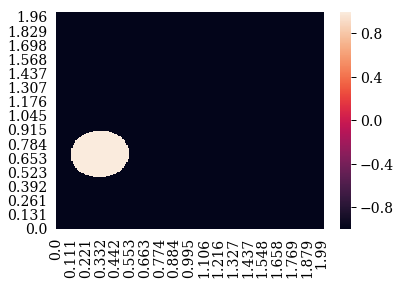

In [13]:
mat = df.y_hat.values.reshape(xx1.shape)
mat = pd.DataFrame(mat, index=z.round(3), columns=z.round(3))
ax = sns.heatmap(mat)
ax.set_ylim(*reversed(ax.get_ylim()))

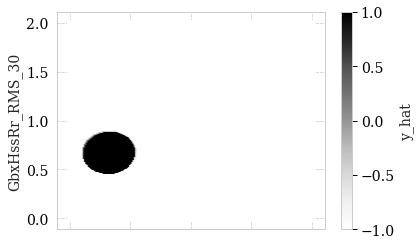

In [14]:
df.plot.scatter(x='GbxHssRr_RMS_13', y='GbxHssRr_RMS_30', c='y_hat')